# CAMERA Workshop 2019

Daniela Ushizima, Alexandre de Siqueira, Stéfan van der Walt

_BIDS @ University of California, Berkeley_

_Lawrence Berkeley National Laboratory - LBNL_

* Support material for the tutorial _Image processing for microCT using scikit-image (Part II)_.

This tutorial will introduce how to analyze three dimensional stacked and volumetric
images in Python, mainly using scikit-image. Here we will learn how to:
  * pre-process data using filtering, binarization and segmentation techniques.
  * inspect, count and measure attributes of objects and regions of interest in the data.
  * visualize 3D data.

Please prepare for the tutorial by [installing the pre-requisite software](preparation.md) beforehand.

For more info:
  * [[CAMERA Workshop 2019]](http://microct.lbl.gov/cameratomo2019/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from skimage import io

In [3]:
input_filename="../data/bead_pack_artifacts_small.tif"
img = io.imread(input_filename)

# Visualizing stacks with itkwidgets
- Visualize 2D and 3D images, point sets, and geometry, e.g. meshes, in Jupyter
- Support for NumPy array images, itk.Image, Dask array images and more
- More info at [[repo]](https://github.com/InsightSoftwareConsortium/itkwidgets)

In [4]:
import itk
from itkwidgets import view

ExecutableNotFound: mvn not found on path /Users/dani/anaconda3/bin:/Users/dani/anaconda3/condabin:/Users/dani/.rbenv/shims:/Users/dani/.rbenv/bin:/Users/dani/miniconda2/bin:/Users/dani/.local/bin:/usr/local/bin:/Users/dani/anaconda/bin:/opt/local/bin:/opt/local/sbin:/Users/dani/anaconda/bin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/opt/X11/bin:/Library/TeX/texbin

## An interactive imshow

In [8]:
aslice = img[len(img)//2,:,:]
image_itk = itk.GetImageFromArray(aslice.astype('uint8'))
view(image_itk)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itkImagePython.itkImageUC2; proxy …

## Volume rendering in the jupyter notebook

In [4]:
#original image
image_itk = itk.GetImageFromArray(img.astype('uint8'))
#view(image_itk, slicing_planes=True, gradient_opacity=0)

In [70]:
#cleaned
image_itk = itk.GetImageFromArray(labeled.astype('uint8'))
#view(image_itk, gradient_opacity=0, cmap = 'hsv')

In [69]:
#a bead
#view(itk.GetImageFromArray(bead.astype('uint8')))

## Downsample for images > 1M voxels

In [68]:
#Quick view of content
downsample = 3 #isotropic downsampling
image_np = cleaned[::downsample,::downsample,::downsample]
image_itk = itk.GetImageFromArray(image_np.astype('uint8'))
#view(image_itk, gradient_opacity=0.2,shadow=False)

## Anisotropic volumes

In [59]:
new_spacing = [4, 1, 1]
image_itk.SetSpacing(new_spacing)
#view(image_itk, cmap='Blues', gradient_opacity=0.4)

In general, there's some much one can segment using only classical filters and thresholding. A complete investigation will often include machine learning methods using unsupervised and supervised classification of voxels.

# Image segmentation:
- image transformations for more suitable image representation
- beyond thresholding: supervised and unsupervised machine learning
- skimage [segmentation](https://scikit-image.org/docs/dev/api/skimage.segmentation.html)
- sklearn [segmentation](https://scikit-learn.org/stable/modules/clustering.html#spectral-clustering)

## Euclidean distance transform

In [60]:
from scipy import ndimage as ndi
edt = ndi.distance_transform_edt(cleaned)

In [64]:
#view(itk.GetImageFromArray(edt.astype('uint8')),shadow=False,cmap='jet')

## Creating markers

In [76]:
from skimage import feature
seeds = feature.peak_local_max(edt, indices = False, footprint=np.ones((3, 3, 3)),
                            labels=labeled) #return sparse matrix instead of array with peaks

In [82]:
markers = label(seeds)
labeled_edt = morphology.watershed(-edt, markers, mask=cleaned)
print('Estimated number of objects in the stack: '+str(np.max(labeled_edt)))

Estimated number of objects in the stack: 183


In [85]:
slicing(labeled_edt,'rainbow')

interactive(children=(IntSlider(value=100, description='z', max=199), Output()), _dom_classes=('widget-interac…

In [88]:
import itk
from itkwidgets import view

image_itk = itk.GetImageFromArray(labeled_edt.astype(np.uint8))
#view(image_itk, cmap='Cold and Hot', rotate=True, gradient_opacity=0.4)

## Supervised classification using markers

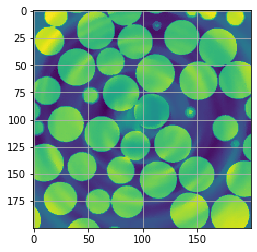

In [89]:
from skimage import segmentation as seg
b = bilat[n,:,:]
plt.imshow(b)
plt.grid()

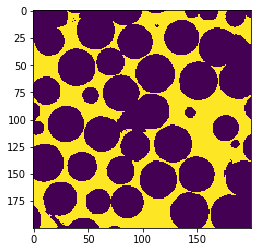

In [93]:
#2D version
markers = (25, 30)  # Experiment with other markers
c = seg.flood(b, markers, tolerance=40)
plt.imshow(c)

In [114]:
#3D version
markers = (n, 25, 30)  # Experiment with other markers
c = seg.flood(bilat, markers, tolerance=40)

In [115]:
c = morphology.binary_dilation(c,selem=aball)
c = morphology.remove_small_objects(255-c, min_size=5000, connectivity=1, in_place=False)
slicing(c)

interactive(children=(IntSlider(value=100, description='z', max=199), Output()), _dom_classes=('widget-interac…

In [116]:
print('Estimated number of objects in the stack: '+str(np.max(label(c))))

Estimated number of objects in the stack: 241


## Unsupervised - kmeans

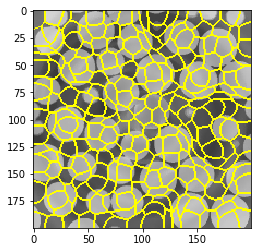

In [117]:
from skimage.segmentation import slic, mark_boundaries
from skimage import restoration
segments = slic(b, n_segments=250, compactness=0.05, enforce_connectivity=True, sigma=10, max_iter=500, multichannel=False) #higher compact = more weight space, more square
plt.imshow(mark_boundaries(b, segments))

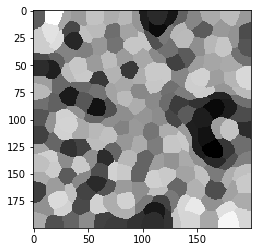

In [119]:
from skimage import color
from skimage.future import graph
output = color.label2rgb(segments, aslice, kind='avg')
plt.imshow(output,cmap='gray')

The routine below can take several minutes depending on your computer configuration

In [125]:
segments = slic(bilat, n_segments=250, compactness=0.05, enforce_connectivity=True, sigma=10, max_iter=50, multichannel=False) #higher compact = more weight space, more square
output = color.label2rgb(segments, bilat, kind='avg')

In [122]:
slicing(output)

interactive(children=(IntSlider(value=100, description='z', max=199), Output()), _dom_classes=('widget-interac…

In [124]:
from skimage import img_as_ubyte
o = img_as_ubyte(output)
#view(o, slicing_planes=True,gradient_opacity=0.4)

# Measuring

In [127]:
from skimage import feature, measure

In [148]:
label = measure.label(cleaned)
regions = measure.regionprops(label,intensity_image=img)

In [152]:
np.max(labeled) #len(regionprops)

121

In [150]:
accum2 = [p.area for p in regions]

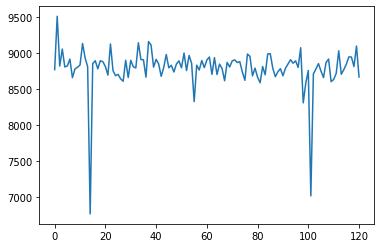

In [151]:
plt.plot(accum2)

In [159]:
area=accum2
convex_area = [p.convex_area for p in regions]
solidity = [p.solidity for p in regions]

In [160]:
type(area)

list

In [165]:
import pandas as pd
beadpd = pd.DataFrame(data = list(zip(area,convex_area,solidity)),
             columns = ['area','convex_area','solidity']
            )

In [166]:
beadpd.to_csv('measurements.csv')

In [167]:
#measurements = measure.regionprops_table(labeled,img,properties=['area','convex_area','solidity'])

In [168]:
import skimage
skimage.__version__

'0.15.0'

In [ ]:
Todo: sklearn example + save stacks: labeled and cleaned

In [ ]:
image_itk = itk.GetImageFromArray(label.astype(np.uint16))
view(image_itk, cmap='Cold and Hot', slicing_planes=True,gradient_opacity=0.4)